<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/Super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteH1MCFW/div2k-train.tfrecord*...:   0%|       …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteH1MCFW/div2k-validation.tfrecord*...:   0%|  …

Dataset div2k downloaded and prepared to ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


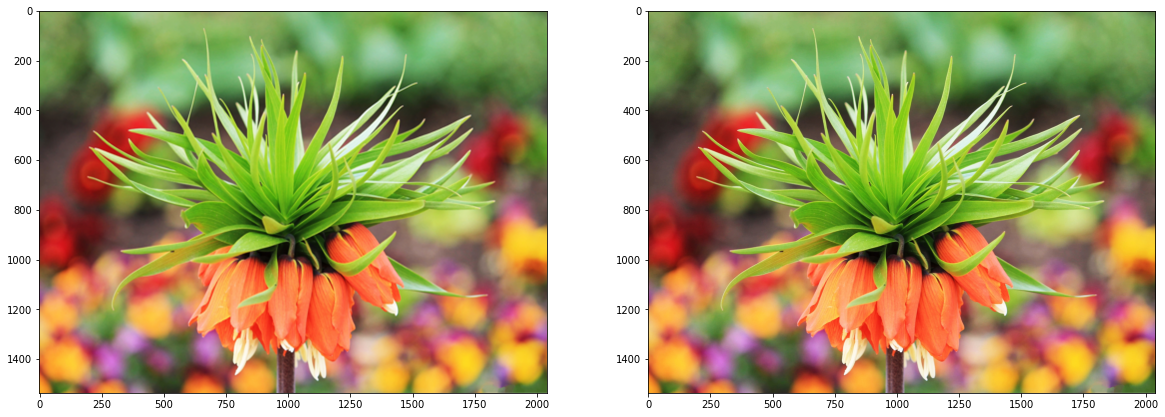

In [1]:
import cv2 #open cv - 이미지 다루는 라이브러리, 이미지 뒤집거나 재사이징하거나 필터효과를 주거나, 도형을 그리거나 모든 효과 
import numpy as np # 배열, 매트릭스 다루는
import matplotlib.pyplot as plt # 그림 그리는 도구 
import tensorflow_datasets as tfds # 텐서플로 내장 데이터, tfds 별명, 별칭 

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", # 데이터셋 이름, bicubic interpolation - 인접한 두셀을 비교해서 보간 linear 두값을 이용해서 새로운 픽셀 예측 bilinear 네값을 이용해서 새로운 픽셀 예측   
    split=["train","validation"], # interpolation 인접한 셀을 이용해서 그들사이의 관계를 파악해서 새로운 픽셀에 적용 
    as_supervised=True # 필수옵션, tuple 형태로 쌍이 붙여짐. False하면 딕셔너리 형태 (저해상도 이미지 픽셀값, 원본 이미지 픽셀값)

# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 3: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정, cv2는 세로와 가로가 반대로 들어가므로 인덱스 값이 반대로
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)


Text(0.5, 1.0, 'HR')

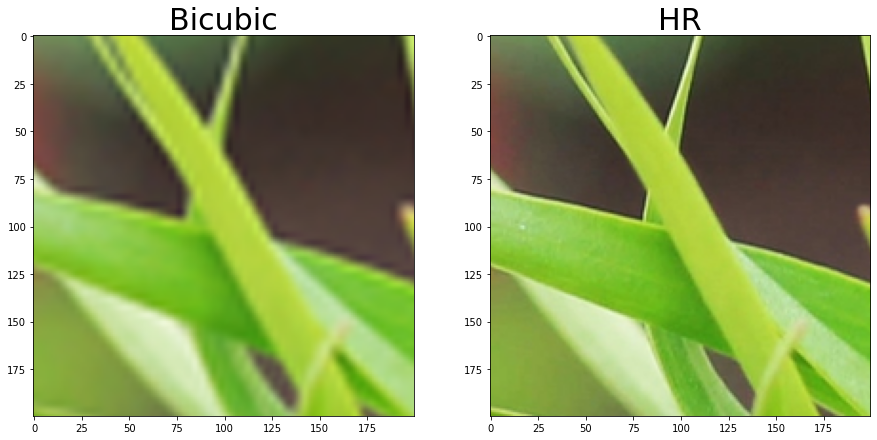

In [2]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top) # 이미지 일부 잘라서 비교하기 crop 
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

In [3]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3]) # 이미지 일부를 랜덤 위치 지정해서 잘라내기 
    hr = tf.cast(hr, tf.float32) / 255. # cast 형변환 int > float
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic") # (1200, 2040) > (96,96)
    lr = tf.image.resize(lr, [96, 96], "bicubic") # 축소시켯다가 확대시키면 화질이 깨짐. 
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16) # map train 데이터 파일에 전체적용,10개 단위로 나눠서 섞음(buffer size), 배치 16, 모델 학습할때마다 다른 결과 
valid = valid.map(preprocessing).batch(16)

In [4]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 32개 사용합니다.
srcnn.add(layers.Conv2D(32, 5, padding="same"))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 re_lu (ReLU)                (None, None, None, 128)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 re_lu_1 (ReLU)              (None, None, None, 64)    0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [5]:
srcnn.compile(
    optimizer="adam", 
    loss="mse"
)

srcnn.fit(train, validation_data=valid, epochs=100)

Epoch 1/100
50/50 [==============================] - 85s 1s/step - loss: 0.0370 - val_loss: 0.0113
Epoch 2/100
50/50 [==============================] - 80s 1s/step - loss: 0.0077 - val_loss: 0.0056
Epoch 3/100
50/50 [==============================] - 80s 1s/step - loss: 0.0057 - val_loss: 0.0042
Epoch 4/100
50/50 [==============================] - 84s 2s/step - loss: 0.0047 - val_loss: 0.0046
Epoch 5/100
50/50 [==============================] - 67s 1s/step - loss: 0.0046 - val_loss: 0.0042
Epoch 6/100
50/50 [==============================] - 68s 1s/step - loss: 0.0046 - val_loss: 0.0040
Epoch 7/100
50/50 [==============================] - 70s 1s/step - loss: 0.0046 - val_loss: 0.0048
Epoch 8/100
50/50 [==============================] - 73s 1s/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/100
50/50 [==============================] - 77s 1s/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/100
50/50 [==============================] - 69s 1s/step - loss: 0.0043 - val_loss: 0.0038
Epoch 11/

In [8]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1 # 모델 학습 결과는 난수와의 연산이기때문에 최대값 1 초과 최소값 0 미만의 값이 가능 
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))
# srcnn 모델, 2014년 논문, 그당시는 최고의 성능 
srcnn_hr = apply_srcnn(bicubic_hr)

1/1 [==============================] - 1s 500ms/step


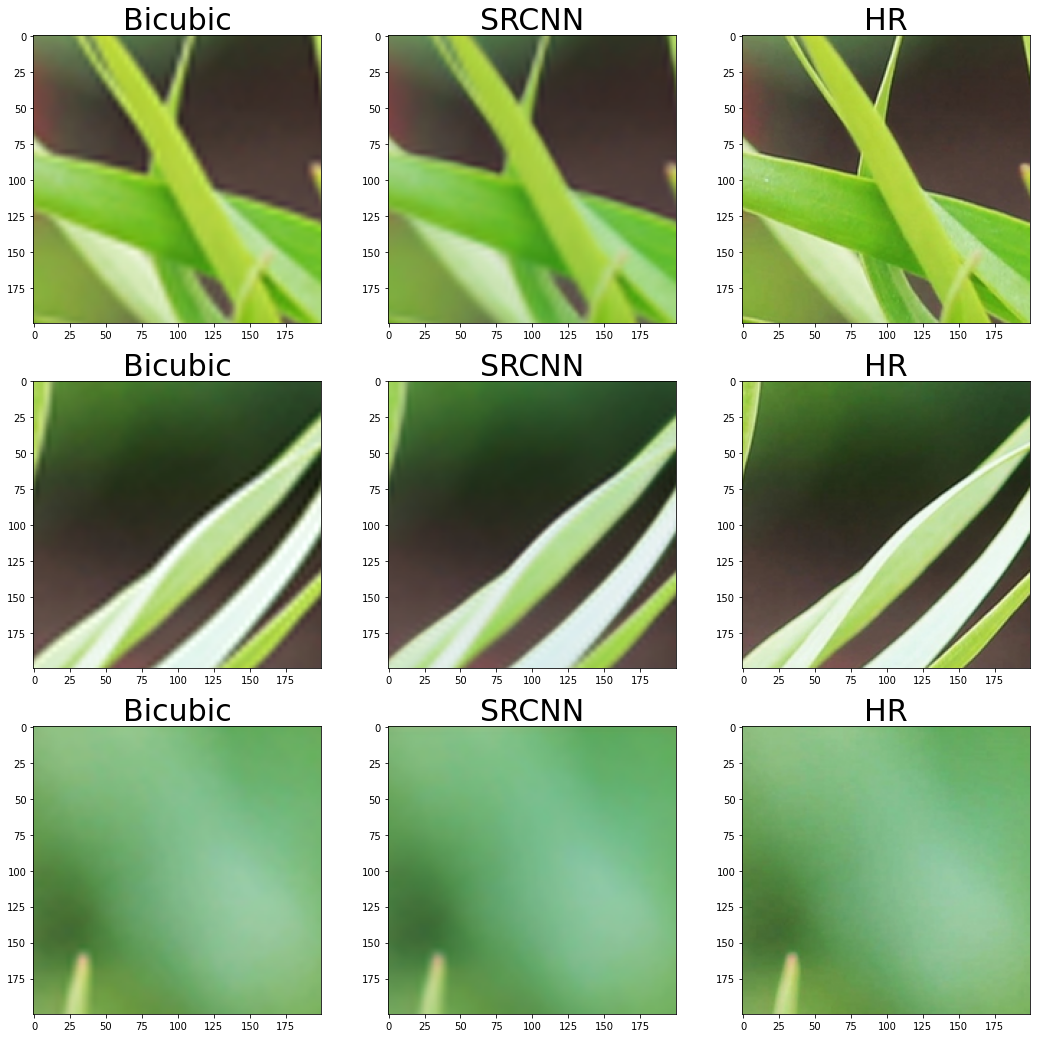

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)